In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(adoptr)


Attaching package: ‘adoptr’


The following object is masked from ‘package:dplyr’:

    n




In [2]:
datadist   <- Normal(two_armed = TRUE)
h0         <- PointMassPrior(.0, 1) # second value is the probability mass
h1         <- PointMassPrior(.2, 1)

alpha      <- 0.05
beta       <- 0.2

In [3]:
ess   <- ExpectedSampleSize(datadist, h1)
power <- Power(datadist, h1)
toer  <- Power(datadist, h0)

In [4]:
# guess group sequential initial design to refine
initial_design <- get_initial_design(
    theta = .2,
    alpha = alpha,
    beta  = beta,
    type  = "two-stage",
    dist  = datadist,
    order = 7L
)

In [5]:
res <- minimize(
  
    ess,

    subject_to(
        power >= 1 - beta,
        toer  <= alpha
    ),

    initial_design
)

design <- res$design

In [6]:
summary(design, ESS = ess, Power = power, MTOER = toer)

TwoStageDesign: n1 = 173 
          futility |                  continue                 | efficacy
      x1:     0.50 |  0.54  0.69  0.94  1.25  1.55  1.80  1.95 |  1.99
  c2(x1):     +Inf | +1.99 +1.86 +1.62 +1.29 +0.89 +0.45 +0.03 |  -Inf
  n2(x1):        0 |   258   245   221   186   145   104    72 |     0
     ESS:    250.209
   Power:      0.800
   MTOER:      0.050


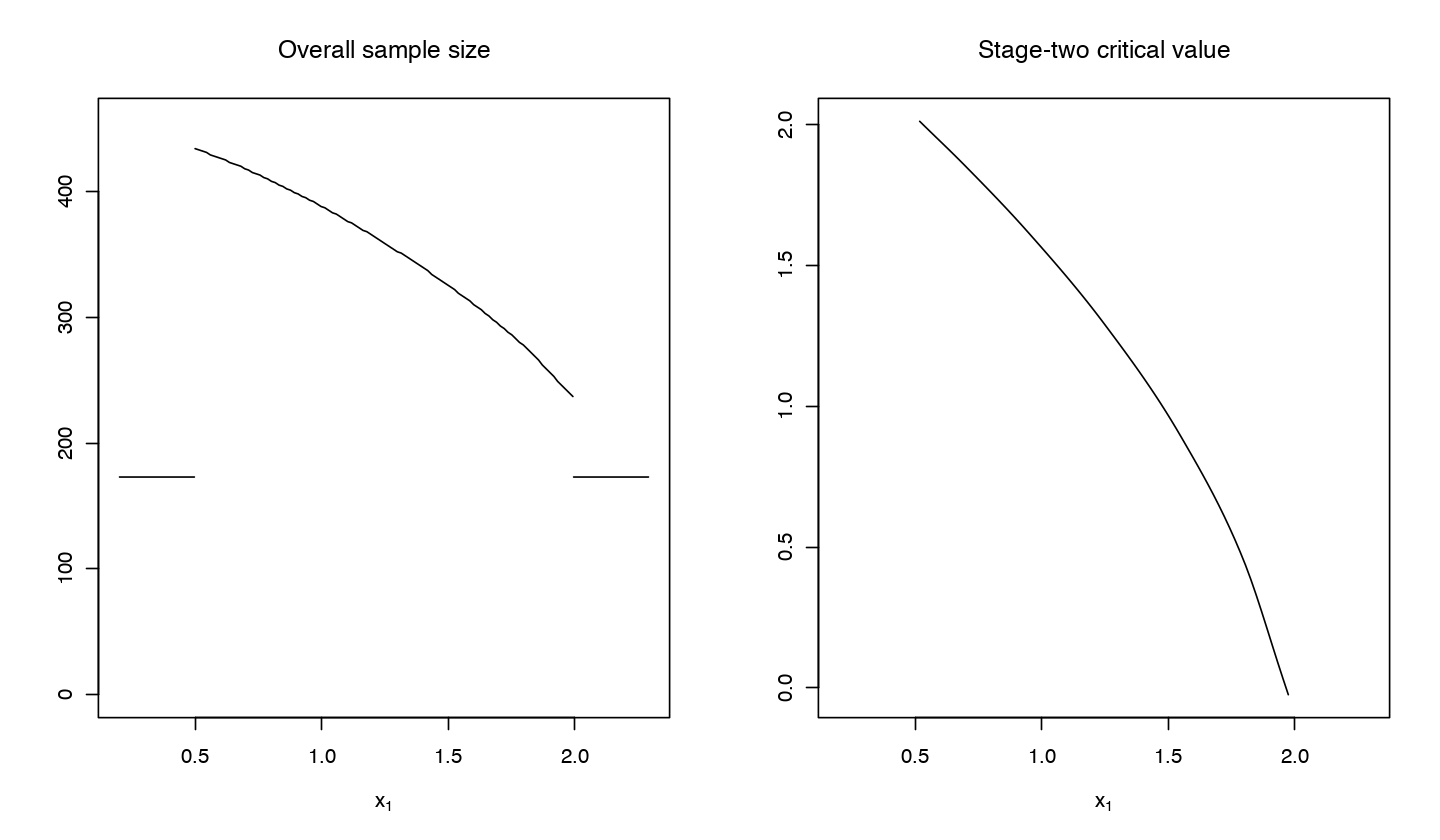

In [7]:
options(repr.plot.width = 12, repr.plot.height = 7)


plot(design)

In [8]:
plt_power <- tibble(
    theta = seq(-.1, .5, by = .01)
) %>% 
mutate(
    Power = map_dbl(theta, ~evaluate(Power(datadist, PointMassPrior(., 1.0)), design))
) %>% {
ggplot(.) + 
    aes(theta, Power) +
    geom_line() +
    scale_x_continuous(expression(theta)) + 
    scale_y_continuous("Power", breaks = seq(0, 1, .1)) + 
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [9]:
plt_n <- tibble(
    x1 = seq(0, 2.5, by = .01)
) %>% 
mutate(
    n = map_dbl(x1, ~n(design, .)),
    n = ifelse(abs(x1 - design@c1f) <= .01, NA, n),
    n = ifelse(abs(x1 - design@c1e) <= .01, NA, n)
) %>% {
ggplot(.) + 
    aes(x1, n) +
    geom_line() +
    scale_x_continuous(expression(x[1])) + 
    scale_y_continuous(expression(n(x[1])), limits = c(0, NA)) + 
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [10]:
plt_c2 <- tibble(
    x1 = seq(0, 2.5, by = .01)
) %>% 
mutate(
    c2 = map_dbl(x1, ~c2(design, .)),
    c2 = ifelse(!is.finite(c2), NA, c2)
) %>% {
ggplot(.) + 
    aes(x1, c2) +
    geom_line() +
    scale_x_continuous(expression(x[1])) + 
    scale_y_continuous(expression(c[2](x[1]))) + 
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

In [11]:
plt_ess <- tibble(
    theta = seq(-.1, .5, by = .01)
) %>% 
mutate(
    ess = map_dbl(theta, ~evaluate(ExpectedSampleSize(datadist, PointMassPrior(., 1.0)), design))
) %>% {
ggplot(.) + 
    aes(theta, ess) +
    geom_line() +
    scale_x_continuous(expression(theta)) + 
    scale_y_continuous("Expected sample size", limits = c(0, NA)) + 
    theme_bw() +
    theme(
        panel.grid.minor = element_blank()
    )
}

Warning message:
“Removed 102 rows containing missing values (geom_path).”


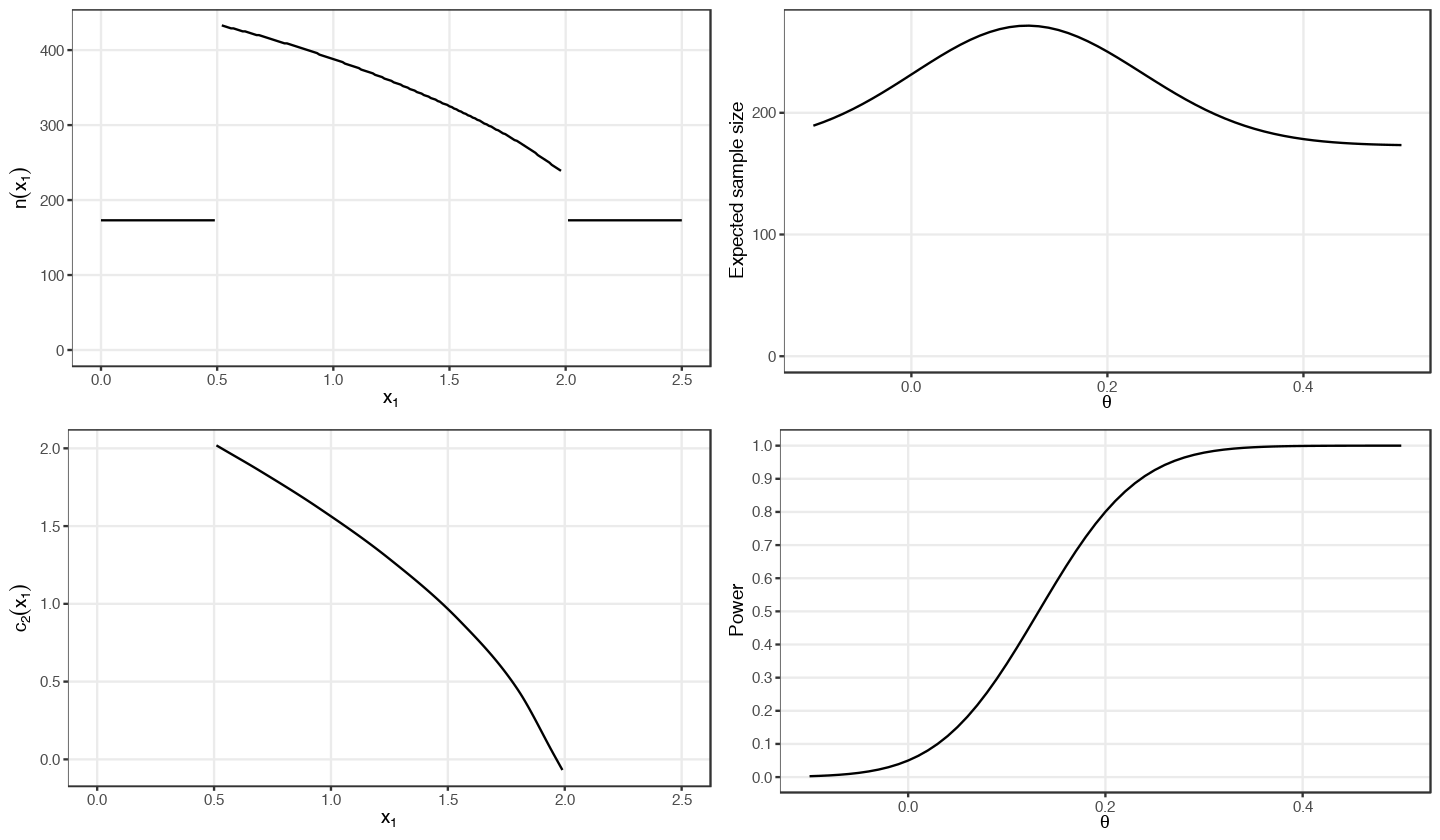

In [12]:
cowplot::plot_grid(plt_n, plt_ess, plt_c2, plt_power)

In [14]:
ggsave("continuous-case-design.pdf", width = 7, height = 6)